In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.RandomState(0)

In [3]:
data = np.loadtxt('data/HDiagramCompilacion-data_31.txt')
data.shape

(31, 3)

In [4]:
# Generate sample data
X = data[:, 0]
l = len(X)
X = X.reshape(l, 1)
X.shape

(31, 1)

In [5]:
np.max(X)

1.965

In [6]:
y = data[:, 1]
y.shape

(31,)

In [7]:
noise = data[:, 2]
noise.shape

(31,)

<ErrorbarContainer object of 3 artists>

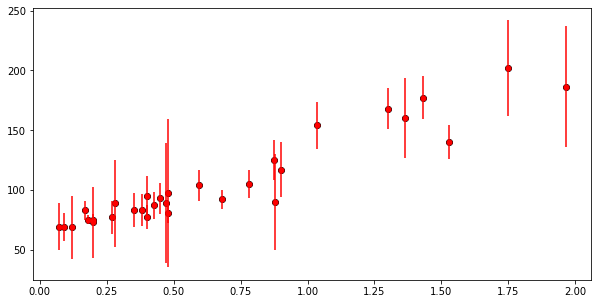

In [8]:
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.errorbar(X.ravel(), y, noise, fmt='r.', markersize=10, label='Observations')

### Trying with scikitlearn kernel and libraries

Hay que aprender a elegir el kernel

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, RationalQuadratic, Matern, ConstantKernel as C

In [10]:
k2 = 0.66**2 * RBF(length_scale=0.5, length_scale_bounds="fixed")
# k3 = 0.66**2 * RationalQuadratic(length_scale=1.2, alpha=0.2)
k3 = 0.66**2 * RationalQuadratic(length_scale=0.5, alpha=0.2)
gp_kernel = k3 #k3 esta mas o menos

In [11]:
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=0.66**2 * RationalQuadratic(alpha=0.2, length_scale=0.5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [12]:
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=0.66**2 * RationalQuadratic(alpha=0.2, length_scale=0.5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [13]:
X_plot = np.linspace(0, 2, 10000)[:, None]
X_plot

array([[0.00000000e+00],
       [2.00020002e-04],
       [4.00040004e-04],
       ...,
       [1.99959996e+00],
       [1.99979998e+00],
       [2.00000000e+00]])

In [14]:
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
y_std

array([25.74696057, 25.74191836, 25.73686128, ..., 25.53972979,
       25.54999261, 25.56018386])

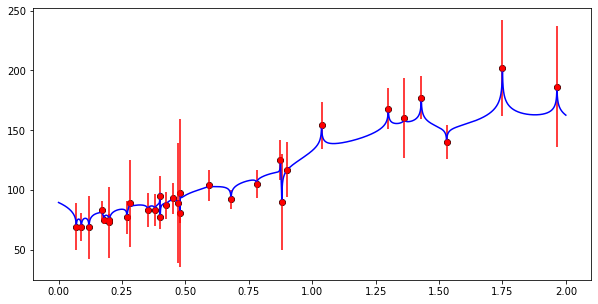

In [15]:
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.errorbar(X.ravel(), y, noise, fmt='r.', markersize=10, label='Observations')
plt.plot(X_plot, y_gpr, 'b-', label='Prediction')

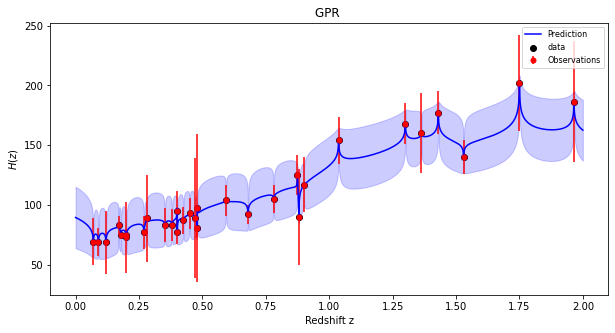

In [16]:
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.errorbar(X.ravel(), y, noise, fmt='r.', markersize=10, label='Observations')
plt.plot(X_plot, y_gpr, 'b-', label='Prediction')

plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='blue',
                 alpha=0.2)

plt.xlabel('Redshift z')
plt.ylabel('$H(z)$')

plt.title('GPR ')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

### Trying wiht George library

In [17]:
import george
from george import kernels

In [18]:
kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
kernel

ConstantKernel(log_constant=7.264024138398544, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(0.5, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)

In [19]:
gp = george.GP(kernel)
gp

In [20]:
gp.compute(X, noise)

In [21]:
X_plot = np.linspace(0, 2, 10000)
y_pred, ypred_var = gp.predict(y, X_plot, return_var=True)

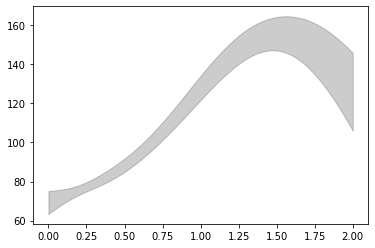

In [22]:
plt.fill_between(X_plot, y_pred - np.sqrt(ypred_var), y_pred + np.sqrt(ypred_var),
                color="k", alpha=0.2)

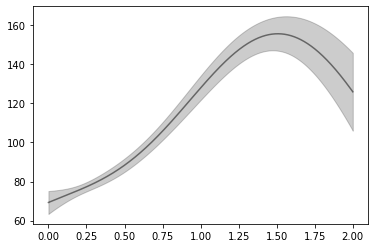

In [23]:
plt.fill_between(X_plot, y_pred - np.sqrt(ypred_var), y_pred + np.sqrt(ypred_var),
                color="k", alpha=0.2)
plt.plot(X_plot, y_pred, "k", lw=1.5, alpha=0.5)

Text(0, 0.5, '$H(z)$')

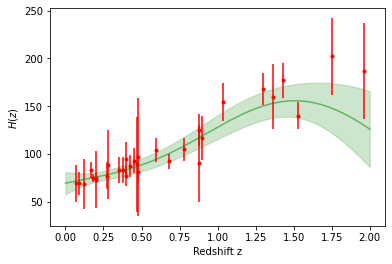

In [24]:
plt.fill_between(X_plot, y_pred - 2*np.sqrt(ypred_var), y_pred + 2*np.sqrt(ypred_var),
                color="g", alpha=0.2)
plt.plot(X_plot, y_pred, "g", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr=noise, fmt=".r", capsize=0)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")

In [25]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -139.30


Se puede utilizar el proceso gausiano con una función minimize de scipy para ajustar los parámetros del max loglike. En la documentación de george, esta combinación suaviza la reconstrucción, no ocurre así en esta notebook.

In [26]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


In [27]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

      fun: 132.61113040834704
 hess_inv: array([[2.05506048, 2.25657603],
       [2.25657603, 4.05940294]])
      jac: array([-4.96636388e-06,  4.79036306e-06])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([9.78869535, 1.30942432])


In [28]:
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))


Final ln-likelihood: -132.61


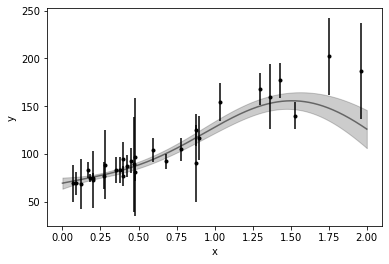

In [29]:
pred, pred_var = gp.predict(y, X_plot, return_var=True)

plt.fill_between(X_plot, y_pred - np.sqrt(ypred_var), y_pred + np.sqrt(ypred_var),
                color="k", alpha=0.2)
plt.plot(X_plot, y_pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr=noise, fmt=".k", capsize=0)

plt.xlabel("x")
plt.ylabel("y");